# SoundScope – Model & App Preparation


This notebook prepares the core machine learning model for **SoundScope**, a project that explores song characteristics using Spotify-style audio features.

For this prototype, we use a small curated dataset (`spotify_tracks.csv`) with synthetic tracks. Each track has:

- Numeric audio features (tempo, danceability, energy, valence, loudness, etc.)
- Categorical tags: **genre**, **mood**, and **era**

In this notebook we will:

1. Load the dataset with pandas
2. Perform basic exploratory analysis and sanity checks
3. Train a baseline **Random Forest classifier** to predict `mood`
4. Evaluate the model with a classification report and confusion matrix
5. Save the trained model and label encoder for later use in a Streamlit app


## 1. Setup


In [1]:
from pathlib import Path
import os

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Make plots a bit smaller and consistent
plt.rcParams["figure.figsize"] = (6, 4)

# Paths
DATA_PATH = Path("../data/spotify_tracks.csv")
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(exist_ok=True)

# Numeric features to use as inputs to the model
FEATURE_COLS = [
    "tempo",
    "danceability",
    "energy",
    "valence",
    "loudness",
    "acousticness",
    "instrumentalness",
    "speechiness",
    "liveness",
    "popularity",
]

# Target we want to predict for the web app
LABEL_COL = "mood"  # classes like: Happy, Energetic, Calm, Sad


## 2. Load dataset and quick preview


In [2]:
# Load the CSV into a DataFrame
df = pd.read_csv(DATA_PATH)

print(f"Loaded {df.shape[0]} tracks with {df.shape[1]} columns.")
print("Columns:", list(df.columns))

df.head()


Loaded 50 tracks with 17 columns.
Columns: ['track_id', 'track_name', 'artist', 'tempo', 'danceability', 'energy', 'valence', 'loudness', 'acousticness', 'instrumentalness', 'speechiness', 'liveness', 'popularity', 'genre', 'mood', 'era', 'spotify_url']


,track_id,track_name,artist,tempo,danceability,energy,valence,loudness,acousticness,instrumentalness,speechiness,liveness,popularity,genre,mood,era,spotify_url
0,1,Again,Fetty Wap,148,0.84,0.72,0.55,-5.5,0.12,0.00,0.12,0.16,82,Hip-Hop,Happy,2010s,https://open.spotify.com/track/3ESSGgWzRf1xvP7...
1,2,The Gummy Bear Song,Gummibar,130,0.86,0.78,0.90,-4.2,0.10,0.00,0.08,0.15,78,Pop,Happy,2000s,https://open.spotify.com/track/6nFYXpBgrNcZjbt...
2,3,Axel F,Crazy Frog,138,0.88,0.92,0.80,-3.8,0.02,0.85,0.04,0.12,80,Electronic,Energetic,2000s,https://open.spotify.com/track/3PB2m8DG0y9j8Ew...
3,4,Cbat,Hudson Mohawke,160,0.79,0.93,0.62,-4.0,0.03,0.90,0.06,0.11,75,Electronic,Energetic,2010s,https://open.spotify.com/track/7Ek68mnhTBdhdgy...
4,5,Slow Dancing in the Dark,Joji,89,0.54,0.55,0.25,-7.5,0.32,0.00,0.04,0.18,84,Alternative,Sad,2010s,https://open.spotify.com/track/6rY5FAWxCdAGllY...


### 2.1 Basic info and descriptive statistics


In [3]:
# Overview of dtypes and non-null counts
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          50 non-null     int64  
 1   track_name        50 non-null     object 
 2   artist            50 non-null     object 
 3   tempo             50 non-null     int64  
 4   danceability      50 non-null     float64
 5   energy            50 non-null     float64
 6   valence           50 non-null     float64
 7   loudness          50 non-null     float64
 8   acousticness      50 non-null     float64
 9   instrumentalness  50 non-null     float64
 10  speechiness       50 non-null     float64
 11  liveness          50 non-null     float64
 12  popularity        50 non-null     int64  
 13  genre             50 non-null     object 
 14  mood              50 non-null     object 
 15  era               50 non-null     object 
 16  spotify_url       50 non-null     object 
dtyp

In [4]:
# Descriptive stats for numeric features
df[FEATURE_COLS].describe().T


,count,mean,std,min,25%,50%,75%,max
tempo,50.0,132.3400,25.217106,89.00,118.5000,127.000,148.000,186.00
danceability,50.0,0.7226,0.103841,0.51,0.6550,0.725,0.800,0.88
energy,50.0,0.7192,0.133016,0.43,0.6125,0.725,0.820,0.95
valence,50.0,0.6386,0.174180,0.18,0.5500,0.650,0.775,0.93
loudness,50.0,-5.4780,1.222792,-8.00,-6.4750,-5.250,-4.325,-3.50
acousticness,50.0,0.1852,0.137711,0.02,0.0925,0.150,0.250,0.55
instrumentalness,50.0,0.0354,0.173219,0.00,0.0000,0.000,0.000,0.90
speechiness,50.0,0.0676,0.046798,0.03,0.0400,0.050,0.060,0.24
liveness,50.0,0.1768,0.034133,0.11,0.1600,0.170,0.200,0.30
popularity,50.0,90.5000,6.267018,70.00,88.5000,92.000,95.000,99.00


### 2.2 Categorical distributions (genre, mood, era)


In [5]:
for col in ["genre", "mood", "era"]:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())



Value counts for genre:
genre
Pop            24
Hip-Hop         7
Rock            6
Electronic      4
Alternative     3
Indie           3
RnB             2
Funk            1
Name: count, dtype: int64

Value counts for mood:
mood
Happy        18
Energetic    16
Calm         10
Sad           6
Name: count, dtype: int64

Value counts for era:
era
2020s    21
2010s    19
2000s     5
1980s     2
1970s     2
1990s     1
Name: count, dtype: int64


### 2.3 Simple visualizations

Even with a tiny dataset, visualizing a few patterns is helpful for storytelling in the final report and web app.


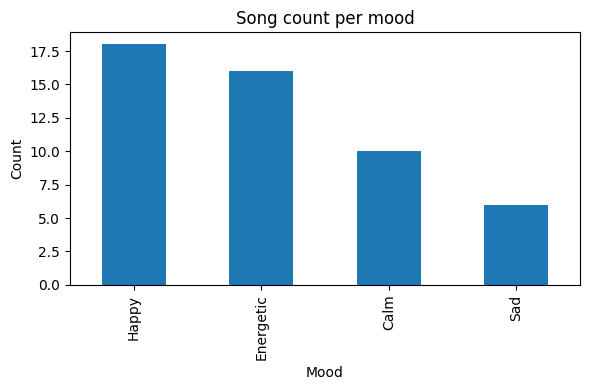

In [6]:
# Mood distribution bar plot
df["mood"].value_counts().plot(kind="bar")
plt.title("Song count per mood")
plt.xlabel("Mood")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


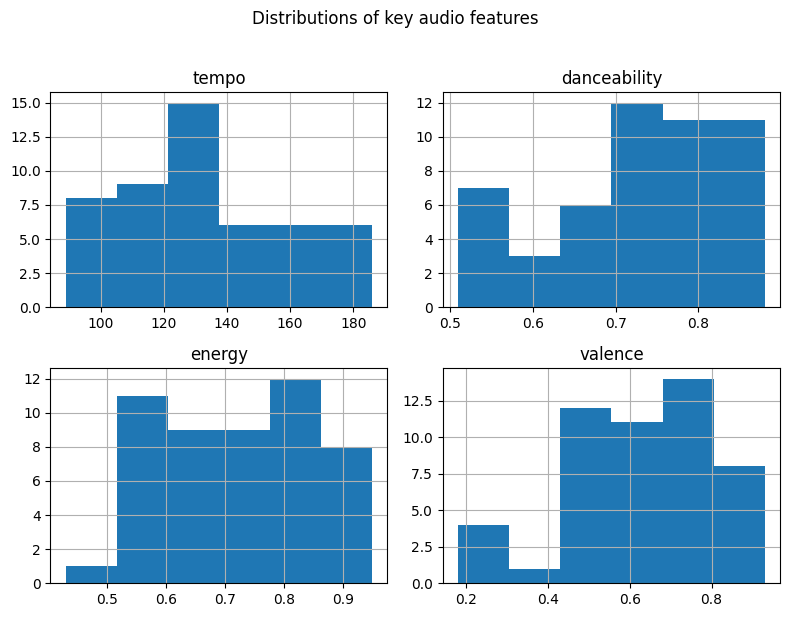

In [7]:
# Histograms for a few core audio features
df[["tempo", "danceability", "energy", "valence"]].hist(bins=6, figsize=(8, 6))
plt.suptitle("Distributions of key audio features", y=1.02)
plt.tight_layout()
plt.show()


## 3. Prepare data for modeling (mood classifier)

We will train a basic **Random Forest classifier** to predict the `mood` of a track from its numeric audio features.

Steps:

1. Select numeric feature columns (`FEATURE_COLS`)
2. Encode `mood` labels as integers using `LabelEncoder`
3. Split into train and test sets


In [8]:
# Features (X) and target (y)
X = df[FEATURE_COLS].copy()
y = df[LABEL_COL].copy()

# Encode mood labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Mood classes:", list(label_encoder.classes_))


Mood classes: ['Calm', 'Energetic', 'Happy', 'Sad']


In [9]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded,
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 35
Test size: 15


## 4. Train baseline Random Forest model


In [10]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print("Training complete.")


Training complete.


## 5. Evaluation: classification report and confusion matrix


In [11]:
target_names = label_encoder.classes_

print("Classification report (mood classifier):\n")
print(classification_report(y_test, y_pred, target_names=target_names))


Classification report (mood classifier):

              precision    recall  f1-score   support

        Calm       0.50      0.67      0.57         3
   Energetic       1.00      0.20      0.33         5
       Happy       0.56      1.00      0.71         5
         Sad       1.00      0.50      0.67         2

    accuracy                           0.60        15
   macro avg       0.76      0.59      0.57        15
weighted avg       0.75      0.60      0.55        15



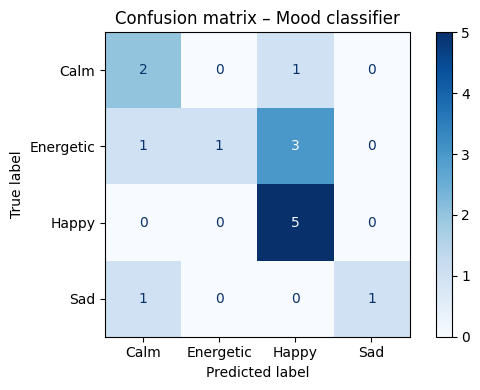

In [12]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap="Blues")
plt.title("Confusion matrix – Mood classifier")
plt.tight_layout()
plt.show()


## 6. Save model artifacts for the web app

To use this model inside a **Streamlit app**, we need to save:

- The trained `RandomForestClassifier`
- The `LabelEncoder` for `mood`
- The list of feature columns used during training (to keep input order consistent)


In [13]:
import joblib

model_path = MODELS_DIR / "mood_classifier_rf.pkl"
le_path = MODELS_DIR / "mood_label_encoder.pkl"
feature_path = MODELS_DIR / "feature_cols.pkl"

joblib.dump(rf_clf, model_path)
joblib.dump(label_encoder, le_path)
joblib.dump(FEATURE_COLS, feature_path)

print("Saved model to:", model_path)
print("Saved label encoder to:", le_path)
print("Saved feature columns to:", feature_path)


Saved model to: ..\models\mood_classifier_rf.pkl
Saved label encoder to: ..\models\mood_label_encoder.pkl
Saved feature columns to: ..\models\feature_cols.pkl


## 7. Next steps

With a working baseline model and saved artifacts, the next phase is to build the **interactive web app** (e.g., with Streamlit):

- Create an `app.py` file
- Load the saved model and label encoder using `joblib.load(...)`
- Let users:
  - Adjust sliders for tempo, energy, danceability, valence, etc.
  - Submit a track profile and see the predicted **mood**
  - Visualize how their custom track compares to existing examples

This notebook will be referenced in the README as the **model training pipeline** that powers the SoundScope web interface.
